<a href="https://colab.research.google.com/github/Davjot/PlantDoc/blob/main/YOLOv5_416_noBB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Install Requirements

In [ ]:
#clone YOLOv5 and 
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt # install dependencies
%pip install -q roboflow

import torch
import os
from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Cloning into 'yolov5'...
remote: Enumerating objects: 15378, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 15378 (delta 4), reused 1 (delta 0), pack-reused 15368
Receiving objects: 100% (15378/15378), 14.34 MiB | 24.12 MiB/s, done.
Resolving deltas: 100% (10516/10516), done.
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 KB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Setup complete. Using torch 2.0.0+cu118 (Tesla T4)


# Step 2: Assemble Our Dataset



In [ ]:
# set up environment
os.environ["DATASET_DIRECTORY"] = "/content/datasets"

In [ ]:
#after following the link above, recieve python code with these fields filled in
from roboflow import Roboflow
rf = Roboflow(api_key="1ccpqcepXl8n0Zk6Q5Fa")
project = rf.workspace("test-rxscv").project("plantdoc-mnyeb")
dataset = project.version(4).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...

Extracting Dataset Version Zip to /content/datasets/Plantdoc-4 in yolov5pytorch:: 100%|██████████| 12134/12134 [00:03<00:00, 3583.61it/s]


# Step 3: Train Our Custom YOLOv5 model

Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** Our dataset locaiton is saved in the `dataset.location`
- **weights:** specify a path to weights to start transfer learning from. Here we choose the generic COCO pretrained checkpoint.
- **cache:** cache images for faster training

In [ ]:
!python train.py --img 416 --batch 16 --epochs 100 --data {dataset.location}/data.yaml --weights yolov5s.pt --cache

2023-04-09 11:33:23.500528: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-09 11:33:24.420673: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
train: weights=yolov5s.pt, cfg=, data=/content/datasets/Plantdoc-4/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_datas

# Evaluate Custom YOLOv5 Detector Performance
Training losses and performance metrics are saved to Tensorboard and also to a logfile.

If you are new to these metrics, the one you want to focus on is `mAP_0.5` - learn more about mean average precision [here](https://blog.roboflow.com/mean-average-precision/).

In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

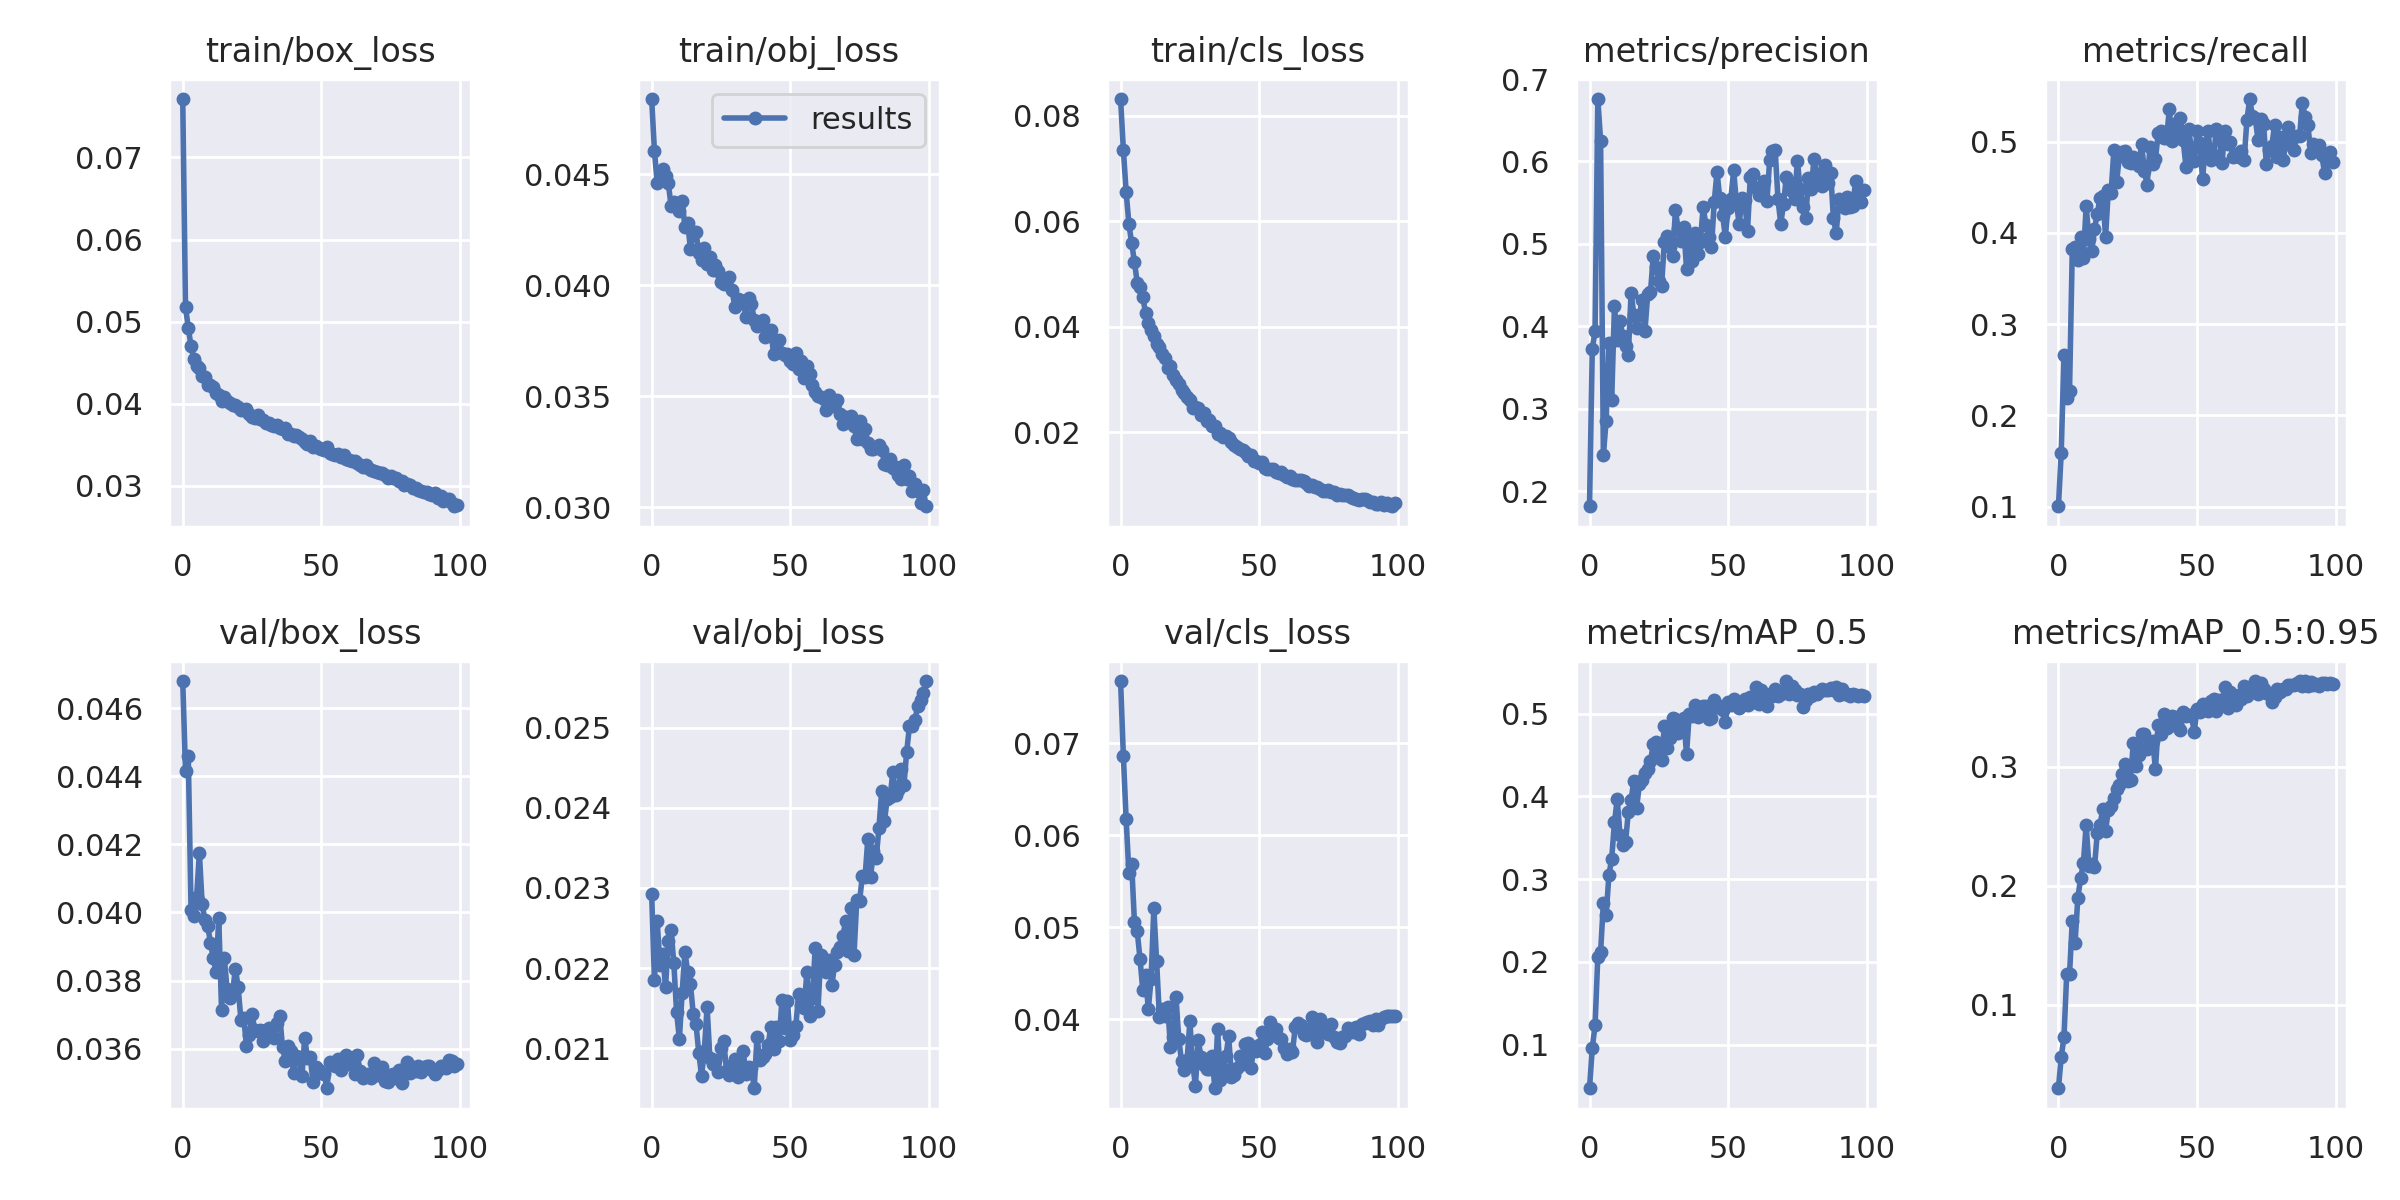

In [ ]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason... 
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/exp/results.png', width=1000)  # view results.png

In [ ]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/exp/train_batch0.jpg', width=900)

#Run Inference  With Trained Weights
Run inference with a pretrained checkpoint on contents of `test/images` folder downloaded from Roboflow.

In [ ]:
!python detect.py --weights runs/train/exp/weights/best.pt --img 416 --conf 0.1 --source {dataset.location}/test/images

detect: weights=['runs/train/exp/weights/best.pt'], source=/content/datasets/Plantdoc-4/test/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-135-g9dd0ad3 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7091035 parameters, 0 gradients, 16.0 GFLOPs
image 1/263 /content/datasets/Plantdoc-4/test/images/-2320-Bacterial-Spot-and-Speck_jpg.rf.b7455b30d05b5f75e38496603393b9b8.jpg: 416x416 2 Tomato Septoria leaf spots, 7.5ms
image 2/263 /content/datasets/Plantdoc-4/test/images/0042241_jpg.rf.01808edf03bd8d34354e672ca28b1a48.jpg: 416x416 5 Apple leafs, 1 Potato leaf, 12 Soyabea

In [ ]:
#display inference on ALL test images

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

# Conclusion and Next Steps



In [ ]:
#export your model's weights for future use
from google.colab import files
files.download('./runs/train/exp/weights/best.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>